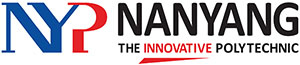

# IT3386 - AI Services in Analytics

## Part 2 - AutoML in Vertex AI

This template contains some steps to help you complete your assignment. Refer to the assignment brief for details on the tasks you are required to perform and add them into the notebook accordingly.

READ ALL INSTRUCTIONS CAREFULLY

### Setup

In [368]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import matplotlib.patches as patches
import ast

In [14]:
# add service key json into env
%env GOOGLE_APPLICATION_CREDENTIALS=key_i223715y.json
%env GOOGLE_APPLICATION_CREDENTIALS

env: GOOGLE_APPLICATION_CREDENTIALS=key_i223715y.json


'key_i223715y.json'

In [15]:
# settings
PROJECT_ID = "i223715y"
BUCKET_NAME = PROJECT_ID + "-3386-aip"
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION = "us-central1"
print(BUCKET_URI)

gs://i223715y-3386-aip


In [16]:
# full path of annotation file, which you have checked in Part 1 during data preparation
IMPORT_FILE = f"{BUCKET_URI}/threat_items_dataset/data.csv"
print(IMPORT_FILE)

gs://i223715y-3386-aip/threat_items_dataset/data.csv


### Initialize SDK

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [17]:
import google.cloud.aiplatform as aip
from google.cloud import storage


aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

In [18]:
storage_client = storage.Client()
buckets = [i for i in storage_client.list_buckets() if i.name == BUCKET_NAME]
buckets

[<Bucket: i223715y-3386-aip>]

In [19]:
mybucket = buckets[0]
print(mybucket.name)

i223715y-3386-aip


### Create the Dataset

Next, create the `Dataset` resource using the `create` method for the `ImageDataset` class, which takes the following parameters:

- `display_name`: The human readable name for the `Dataset` resource.
- `gcs_source`: A list of one or more dataset index files to import the data items into the `Dataset` resource.
- `import_schema_uri`: The data labeling schema for the data items.

Depending on the number of images you have, this operation may take 10 to 30 minutes.

Increase the polling duration from 900s to 3600s to prevent timeout when creating your dataset in Vertex AI.

In [20]:
from google.api_core.future.polling import DEFAULT_POLLING

print(DEFAULT_POLLING)
### Set the default timeout to an hour
DEFAULT_POLLING._timeout = 3600

print(DEFAULT_POLLING)

<Retry predicate=<function if_exception_type.<locals>.if_exception_type_predicate at 0x108df0280>, initial=1.0, maximum=20.0, multiplier=1.5, timeout=3600, on_error=None>
<Retry predicate=<function if_exception_type.<locals>.if_exception_type_predicate at 0x108df0280>, initial=1.0, maximum=20.0, multiplier=1.5, timeout=3600, on_error=None>


Choose a display name for your model. This will be reflected in the Google console.

In [21]:
# e.g. display_name = 'masks'
display_name = 'threat_detector_v1'

In [22]:
# deleting the incorrectly created datasets

# for i in aip.ImageDataset.list():
#     i.delete()

In [23]:
# send a request to server to create a dataset for object detection by importing images from your bucket to Vertex AI platform
# once this cell executes, the server will try to create your dataset; even if your kernel dies in the process,
# the server will continue running until it completes creating the dataset
# hence if you kernel dies in the process, you need not run this cell again; see next cell

# aip already has project id and bucket name from aip.init()
dataset = aip.ImageDataset.create(
    display_name=display_name,
    gcs_source=[IMPORT_FILE],
    import_schema_uri=aip.schema.dataset.ioformat.image.bounding_box,
)

print(dataset.resource_name)

Creating ImageDataset
Create ImageDataset backing LRO: projects/101663845876/locations/us-central1/datasets/3099932846781890560/operations/4261172053773647872
ImageDataset created. Resource name: projects/101663845876/locations/us-central1/datasets/3099932846781890560
To use this ImageDataset in another session:
ds = aiplatform.ImageDataset('projects/101663845876/locations/us-central1/datasets/3099932846781890560')
Importing ImageDataset data: projects/101663845876/locations/us-central1/datasets/3099932846781890560
Import ImageDataset data backing LRO: projects/101663845876/locations/us-central1/datasets/3099932846781890560/operations/402150123070554112
ImageDataset data imported. Resource name: projects/101663845876/locations/us-central1/datasets/3099932846781890560
projects/101663845876/locations/us-central1/datasets/3099932846781890560


*Example output:*

<pre>
Creating ImageDataset
Create ImageDataset backing LRO: projects/122765136922/locations/us-central1/datasets/2688954641772707840/operations/8326596952942706688
ImageDataset created. Resource name: projects/122765136922/locations/us-central1/datasets/2688954641772707840
To use this ImageDataset in another session:
ds = aiplatform.ImageDataset('projects/122765136922/locations/us-central1/datasets/2688954641772707840')
Importing ImageDataset data: projects/122765136922/locations/us-central1/datasets/2688954641772707840
Import ImageDataset data backing LRO: projects/122765136922/locations/us-central1/datasets/2688954641772707840/operations/805585575233978368
<span style="background-color: #FFFF00">ImageDataset data imported.</span> Resource name: projects/122765136922/locations/us-central1/datasets/2688954641772707840
projects/122765136922/locations/us-central1/datasets/1217403463529398272
</pre>

In [ ]:
# if kernel died, run this cell to get a reference to your dataset; if dataset is empty, it means the server is still working
# on it; wait a while and run again
# 
# dataset = aip.ImageDataset.list()[0]
# dataset

In [31]:
dataset

resource name: projects/101663845876/locations/us-central1/datasets/3099932846781890560

*Sample output:* 
```
<google.cloud.aiplatform.datasets.image_dataset.ImageDataset object at 0x000002C0965245B0> 
resource name: projects/122765136922/locations/us-central1/datasets/1217403463529398272
```

> &#128161; **Progress Check #1** - Vertex AI console 



### Training

To train an AutoML model, you need to perform two steps: 
1. Create a training pipeline
2. Run the pipeline (i.e. actual training, estimated 1 - 2 hours)

<span style="color:red"><b>&#9888; IMPORTANT</b></span>

You are encouraged to leave your local terminal running so that the cell can run to completion. 


<span style="color:red">You have <u>ONE</u> attempt to train your model so verify all settings and data before you continue. You will be penalised under Resource Management if you need to retrain your model. Contact your tutor immediately before you retrain your model.</span>


**Create training pipeline**

Reference: [AutoMLImageTrainingJob](https://cloud.google.com/python/docs/reference/aiplatform/1.9.0/google.cloud.aiplatform.AutoMLImageTrainingJob)

An AutoML training pipeline is created with the `AutoMLImageTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `prediction_type`: The type task to train the model for.
  - `object_detection`: An image object detection model.
- `multi_label`: If a classification task, whether single (`False`) or multi-labeled (`True`).
- `model_type`: The type of model for deployment.
  - `CLOUD_LOW_LATENCY_`: Optimized for latency over accuracy for deployment on Google Cloud.
- `base_model`: (optional) Transfer learning from existing `Model` resource -- supported for image classification only.

The instantiated object is the DAG (directed acyclic graph) for the training job.

In [32]:
# use the following parameters; do not change
dag = aip.AutoMLImageTrainingJob(
    display_name=display_name,
    prediction_type="object_detection",
    multi_label=False,
    model_type="CLOUD_LOW_LATENCY_1",
    base_model=None,
)

print(dag)

*Example output:*

    <google.cloud.aiplatform.training_jobs.AutoMLImageTrainingJob object at 0x7f806a6116d0>

#### Run the training pipeline

Next, you run the DAG to start the training job by invoking the method `run`, with the following parameters:

- `dataset`: The `Dataset` resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).
- `validation_fraction_split`: The percentage of the dataset to use for validation.
- `budget_milli_node_hours`: Maximum training time specified in unit of millihours (1000 = hour).
- `disable_early_stopping`: If `True`, training maybe completed before using the entire budget if the service believes it cannot further improve on the model objective measurements.

The `run` method returns the `Model` resource when completed.

<span style="color:red">&#9888; Once the cell below executes without error, training will start at the server and you will receive periodic status that the pipeline is running. If the display hangs or your laptop reboots or your kernel dies, etc., do not run the cell again. Proceed to next section - Evaluation.</span>

In [33]:
# use the following parameters; do not change 
# it takes about 1 to 2 hours to complete this cell
model = dag.run(
    dataset=dataset,
    model_display_name=display_name,
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    budget_milli_node_hours=20000,
    disable_early_stopping=False,
)


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7927331742225006592?project=101663845876
AutoMLImageTrainingJob projects/101663845876/locations/us-central1/trainingPipelines/7927331742225006592 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/101663845876/locations/us-central1/trainingPipelines/7927331742225006592 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/101663845876/locations/us-central1/trainingPipelines/7927331742225006592 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/101663845876/locations/us-central1/trainingPipelines/7927331742225006592 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/101663845876/locations/us-central1/trainingPipelines/7927331742225006592 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/101663845876/locations/us-central1/trainingPipeline

*Example output:*

<pre>
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5745330679017635840?project=636590004944
AutoMLImageTrainingJob projects/636590004944/locations/us-central1/trainingPipelines/5745330679017635840 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLImageTrainingJob projects/636590004944/locations/us-central1/trainingPipelines/5745330679017635840 current state:
PipelineState.PIPELINE_STATE_RUNNING
...

AutoMLImageTrainingJob run completed. Resource name: projects/636590004944/locations/us-central1/trainingPipelines/5745330679017635840
<span style="background-color: #FFFF00">Model available at projects/636590004944/locations/us-central1/models/486659239616446464</span>
</pre>

> &#128161; **Progress Check #2** - Vertex AI console 

### Evaluation

Reference: [Evaluate AutoML image object detection models](https://cloud.google.com/vertex-ai/docs/image-data/object-detection/evaluate-model)

**Review model evaluation score**

After your model has finished training, you can review the evaluation scores for it.

First, you need to get a reference to the new model. As with datasets, you can either use the reference to the model variable you created when you deployed the model or you can list all of the models in your project.

<span style="color:red">You should only have one model that completed training. If you have more than one trained model, you will be penalised under resource management.</span>

In [123]:
# your model will appear after training is completed
# if you arrive here because your kernel died during training, keep running this cell until you see your model appears
aip.Model.list()

 resource name: projects/101663845876/locations/us-central1/models/4546266176086343680]

*Example output:*
```
[<google.cloud.aiplatform.models.Model object at 0x000002C0985F56A0> 
 resource name: projects/122765136922/locations/us-central1/models/6037367770583138304]
```

In [124]:
# Get model resource ID
models = aip.Model.list()

# Get a reference to the Model Service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
model_service_client = aip.gapic.ModelServiceClient(client_options=client_options)

model_evaluations = model_service_client.list_model_evaluations(
    parent=models[0].resource_name
)
model_evaluation = list(model_evaluations)[0]
print(model_evaluation)

name: "projects/101663845876/locations/us-central1/models/4546266176086343680@1/evaluations/6523538904346263552"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/image_object_detection_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "boundingBoxMeanAveragePrecision"
      value {
        number_value: 0.7608152
      }
    }
    fields {
      key: "boundingBoxMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 0.025296668
                          }
                        }
                        fields {
                          key: "f1Score"
             

In [125]:
# boundingBoxMetrics

# evaluatedBoundingBoxCount

# boundingBoxMeanAveragePrecision
    
metrics = model_evaluation.metrics
bounding_box_map = metrics["boundingBoxMeanAveragePrecision"]
print(f"Average precision of the bounding box: {bounding_box_map}")

Average precision of the bounding box: 0.7608152


In [126]:
bounding_box_metrics = metrics["boundingBoxMetrics"]
for i in bounding_box_metrics: 
    print("IOU THRESHOLD:", i['iouThreshold'])
    print("MEAN AVG PRECISION:", i["meanAveragePrecision"])
    print("================================================")
    for j in i["confidenceMetrics"]:
        print(f"CONFIDENCE THRESHOLD: {j['confidenceThreshold']}")
        print(f"F1 SCORE: {j.get('f1Score', 0.0)}")
        print(f"PRECISION: {j['precision']}")
        print(f"RECALL: {j['recall']}")
    print("\n\n")

IOU THRESHOLD: 0.9
MEAN AVG PRECISION: 0.11281456
CONFIDENCE THRESHOLD: 0.025296668
F1 SCORE: 0.018552875
PRECISION: 0.009615385
RECALL: 0.2631579
CONFIDENCE THRESHOLD: 0.42156655
F1 SCORE: 0.22857143
PRECISION: 0.25
RECALL: 0.21052632
CONFIDENCE THRESHOLD: 0.6133529
F1 SCORE: 0.19354838
PRECISION: 0.25
RECALL: 0.15789473
CONFIDENCE THRESHOLD: 0.72497076
F1 SCORE: 0.15384616
PRECISION: 0.2857143
RECALL: 0.10526316
CONFIDENCE THRESHOLD: 0.82190263
F1 SCORE: 0.0952381
PRECISION: 0.5
RECALL: 0.05263158
CONFIDENCE THRESHOLD: 0.8517188
F1 SCORE: 0.0
PRECISION: 0.0
RECALL: 0.0



IOU THRESHOLD: 0.05
MEAN AVG PRECISION: 0.9408136
CONFIDENCE THRESHOLD: 0.025296668
F1 SCORE: 0.07050093
PRECISION: 0.036538463
RECALL: 1.0
CONFIDENCE THRESHOLD: 0.11202502
F1 SCORE: 0.33027524
PRECISION: 0.2
RECALL: 0.94736844
CONFIDENCE THRESHOLD: 0.19815534
F1 SCORE: 0.7555555
PRECISION: 0.65384614
RECALL: 0.8947368
CONFIDENCE THRESHOLD: 0.42156655
F1 SCORE: 0.9142857
PRECISION: 1.0
RECALL: 0.84210527
CONFIDENCE 

In [129]:
rows = []

for entry in bounding_box_metrics:
    iou_threshold = entry["iouThreshold"]
    mean_avg_precision = entry["meanAveragePrecision"]
    for metric in entry["confidenceMetrics"]:
        rows.append({
            "IOU Threshold": iou_threshold,
            "Mean Average Precision": mean_avg_precision,
            "Confidence Threshold": metric["confidenceThreshold"],
            "F1 Score": metric.get("f1Score", 0.0),
            "Precision": metric["precision"],
            "Recall": metric["recall"]
        })


results_df = pd.DataFrame(rows)
results_df

,IOU Threshold,Mean Average Precision,Confidence Threshold,F1 Score,Precision,Recall
0,0.90,0.112815,0.025297,0.018553,0.009615,0.263158
1,0.90,0.112815,0.421567,0.228571,0.250000,0.210526
2,0.90,0.112815,0.613353,0.193548,0.250000,0.157895
3,0.90,0.112815,0.724971,0.153846,0.285714,0.105263
4,0.90,0.112815,0.821903,0.095238,0.500000,0.052632
...,...,...,...,...,...,...
266,0.45,0.930544,0.756907,0.416667,1.000000,0.263158
267,0.45,0.930544,0.767660,0.347826,1.000000,0.210526
268,0.45,0.930544,0.820913,0.272727,1.000000,0.157895
269,0.45,0.930544,0.821903,0.190476,1.000000,0.105263


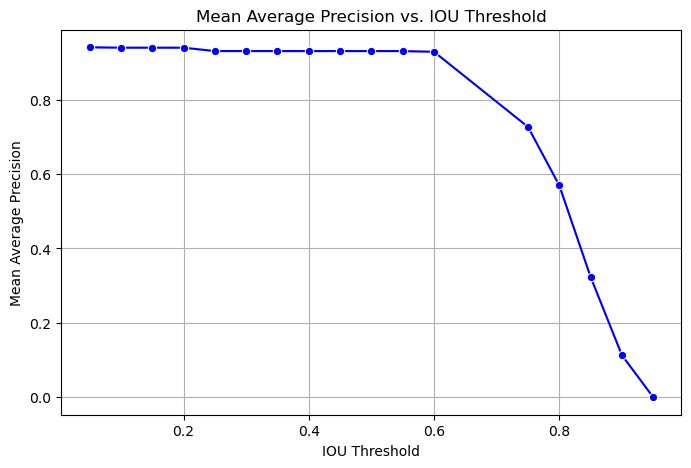

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="IOU Threshold", y="Mean Average Precision", marker="o", color="blue")
plt.title("Mean Average Precision vs. IOU Threshold")
plt.xlabel("IOU Threshold")
plt.ylabel("Mean Average Precision")
plt.grid(True)
plt.show()

<div class="alert alert-info" role="alert">
From the curve, it can be seen that for a high mean average precision, an IOU threshold of less than 0.6 would be ideal. Anything higher would lead to a decrease which will hurt the model performance. 
</div>

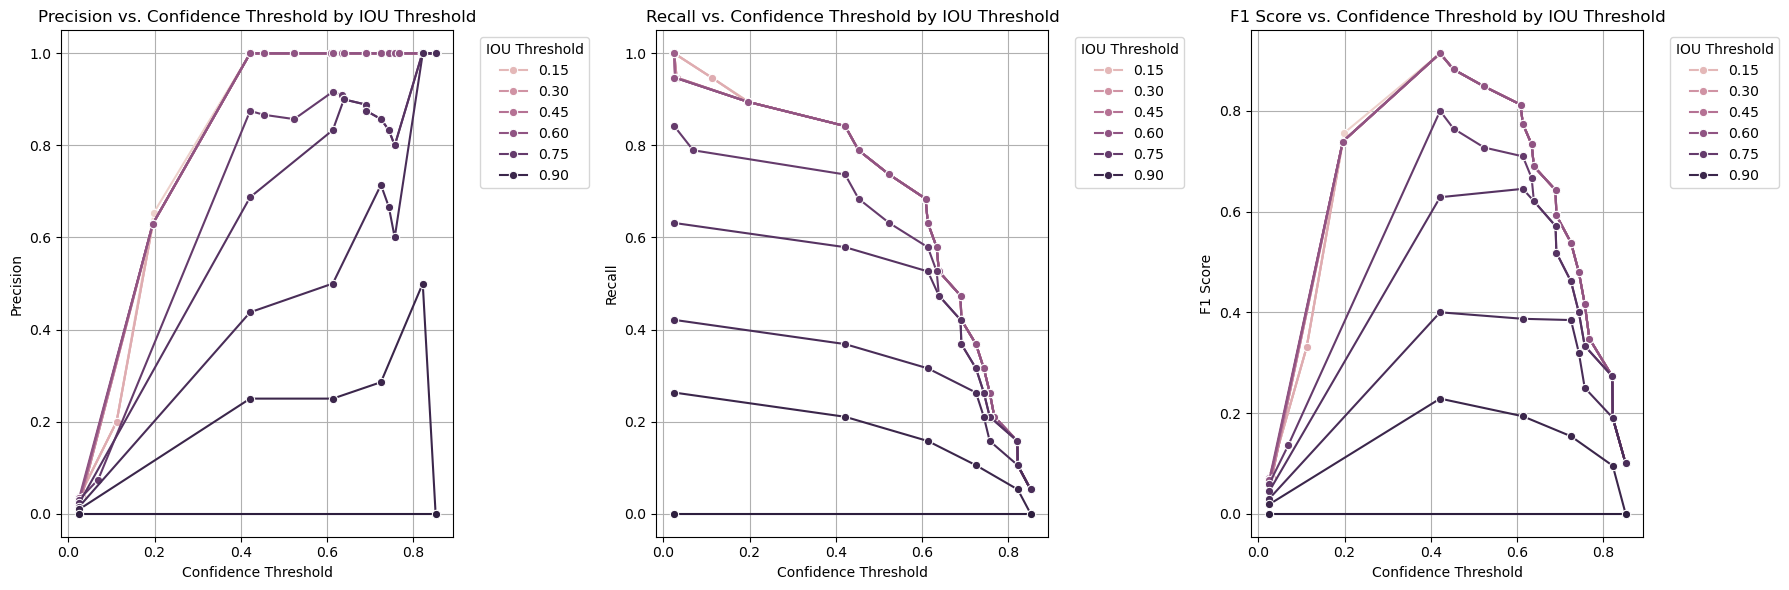

In [237]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1) 
sns.lineplot(data=results_df, x="Confidence Threshold", y="Precision", hue="IOU Threshold", marker="o")
plt.title("Precision vs. Confidence Threshold by IOU Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.legend(title="IOU Threshold", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(1, 3, 2) 
sns.lineplot(data=results_df, x="Confidence Threshold", y="Recall", hue="IOU Threshold", marker="o")
plt.title("Recall vs. Confidence Threshold by IOU Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.legend(title="IOU Threshold", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(1, 3, 3) 
sns.lineplot(data=results_df, x="Confidence Threshold", y="F1 Score", hue="IOU Threshold", marker="o")
plt.title("F1 Score vs. Confidence Threshold by IOU Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.legend(title="IOU Threshold", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


<div class="alert alert-info" role="alert">
Analyzing the performance curves, it is evident that setting the confidence threshold to approximately 0.4 achieves higher F1 scores and precision. Meanwhile, a low IoU threshold in the range of 0.15 to 0.30 complements this setting effectively. For recall, optimal performance is observed at lower confidence thresholds of around 0.2, though it also benefits from IoU thresholds of approximately 0.6. 
</div>

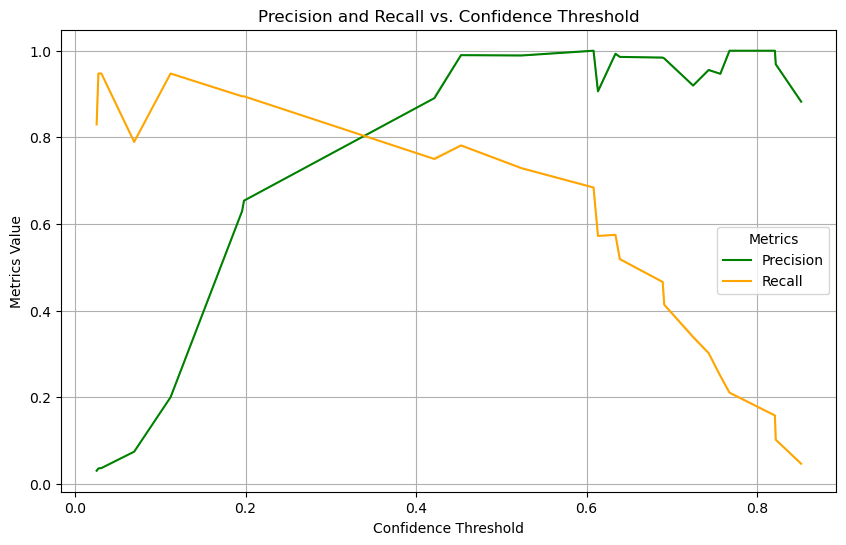

In [176]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="Confidence Threshold", y="Precision", label="Precision", color="green", errorbar=('ci', False))
sns.lineplot(data=results_df, x="Confidence Threshold", y="Recall", label="Recall", color="orange", errorbar=('ci', False))
plt.title("Precision and Recall vs. Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Metrics Value")
plt.legend(title="Metrics")
plt.grid(True)
plt.show()

<div class="alert alert-info" role="alert">
These curves show the tradeoff between precision and recall, in our case, recall is very important metric. This is because a false negative means a threat goes undetected, leading to catastrophic outcomes. In a security context, ensuring that no threats are missed is usually the top priority, even if it means occasionally flagging innocent items (false positives). 
<br><br>
Focusing on recall, it can be seen that a score of 0.2 to 0.3 can be desired. 
</div>

In [143]:
parent = model_service_client.model_evaluation_path(
    project=PROJECT_ID, location=REGION, model="4546266176086343680@1", evaluation="6523538904346263552"
)
response = model_service_client.list_model_evaluation_slices(parent=parent)
list(response)[0]

name: "projects/101663845876/locations/us-central1/models/4546266176086343680/evaluations/6523538904346263552/slices/3577637845385297618"
slice_ {
  dimension: "annotationSpec"
  value: "KNIFE"
}
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/image_object_detection_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "boundingBoxMeanAveragePrecision"
      value {
        number_value: 0.83634454
      }
    }
    fields {
      key: "boundingBoxMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 0.025394456
                          }
                        }
   

In [169]:
data = []

for i in response:
    slice_value = i.slice_.value  
    
    for j in i.metrics["boundingBoxMetrics"]:
        iou_threshold = j["iouThreshold"]
        mean_avg_precision = j["meanAveragePrecision"]
    
        for k in j["confidenceMetrics"]:
            confidence_threshold = k["confidenceThreshold"]
            f1_score = k.get("f1Score", 0.0)
            precision = k["precision"]
            recall = k["recall"]
            
            data.append({
                "Slice": slice_value,
                "IoU Threshold": iou_threshold,
                "Mean Average Precision": mean_avg_precision,
                "Confidence Threshold": confidence_threshold,
                "F1 Score": f1_score,
                "Precision": precision,
                "Recall": recall
            })

slice_score_df = pd.DataFrame(data)
slice_score_df

,Slice,IoU Threshold,Mean Average Precision,Confidence Threshold,F1 Score,Precision,Recall
0,KNIFE,0.90,0.3,0.025394,0.024242,0.012500,0.4
1,KNIFE,0.90,0.3,0.639059,0.250000,0.333333,0.2
2,KNIFE,0.90,0.3,0.821903,0.333333,1.000000,0.2
3,KNIFE,0.05,1.0,0.025394,0.060606,0.031250,1.0
4,KNIFE,0.05,1.0,0.608161,0.888889,1.000000,0.8
...,...,...,...,...,...,...,...
283,GUN,0.45,1.0,0.025398,0.079365,0.041322,1.0
284,GUN,0.45,1.0,0.633877,0.888889,1.000000,0.8
285,GUN,0.45,1.0,0.691136,0.750000,1.000000,0.6
286,GUN,0.45,1.0,0.724971,0.571429,1.000000,0.4


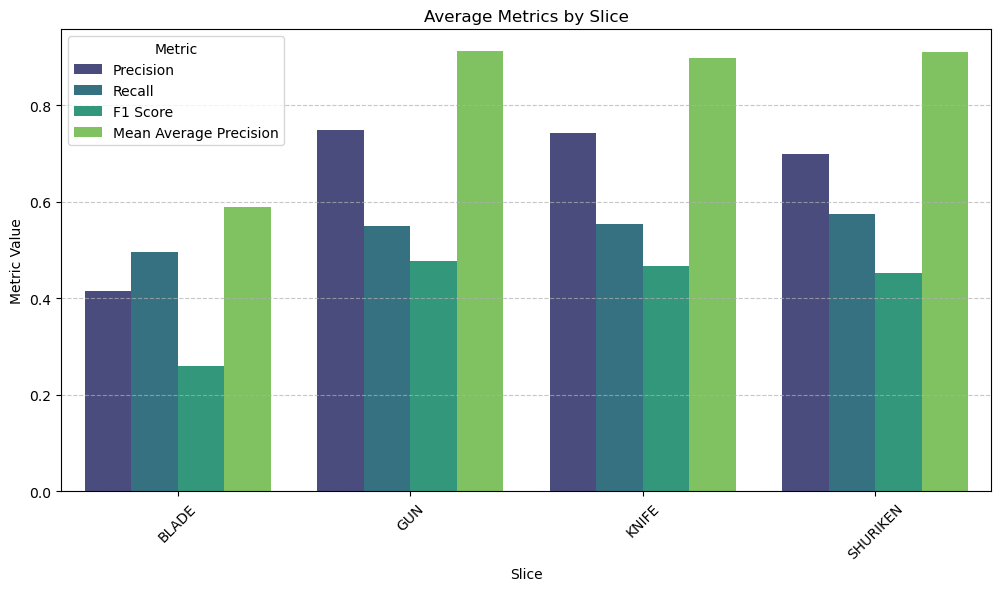

In [193]:
slice_agg_metrics = slice_score_df.groupby("Slice")[["Precision", "Recall", "F1 Score", "Mean Average Precision"]].mean().reset_index()

plt.figure(figsize=(12, 6))
melted = slice_agg_metrics.melt(id_vars="Slice", value_vars=["Precision", "Recall", "F1 Score", "Mean Average Precision"])
sns.barplot(data=melted, x="Slice", y="value", hue="variable", palette="viridis")
plt.title("Average Metrics by Slice")
plt.xlabel("Slice")
plt.ylabel("Metric Value")
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info" role="alert">
Looking at the overall performance across all the classes, it can be seen that the BLADE class is lacking in performance while the other classes seem to be performing well and relatively similar across all the other metrics. This means that there needs to be more focus put on the BLADE class when improving or retraining the model, getting more data for this class. 
</div>

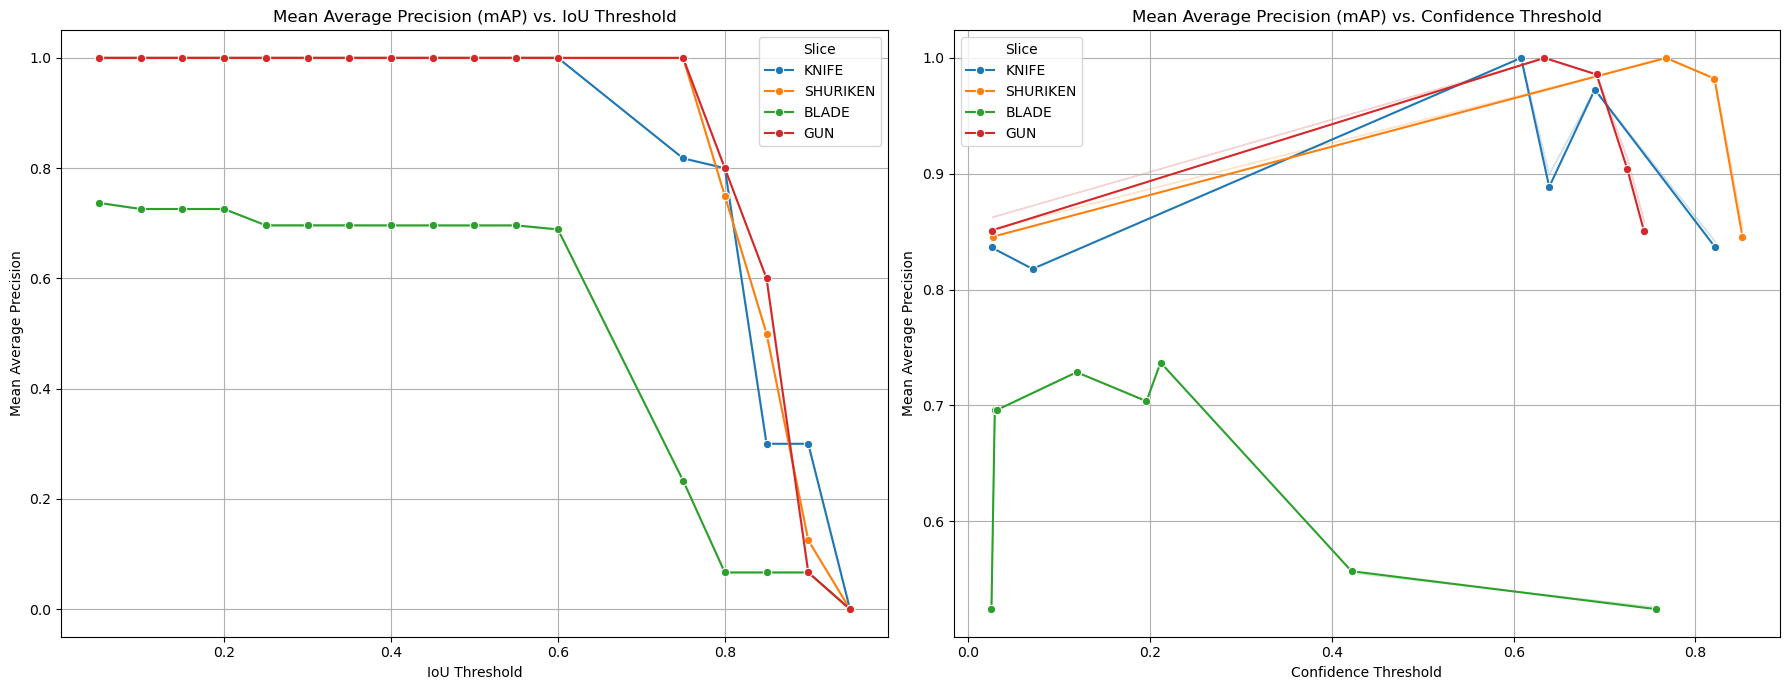

In [234]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)  
sns.lineplot(data=slice_score_df, x="IoU Threshold", y="Mean Average Precision", hue="Slice", marker="o", errorbar=('ci', False))
plt.title("Mean Average Precision (mAP) vs. IoU Threshold")
plt.xlabel("IoU Threshold")
plt.ylabel("Mean Average Precision")
plt.grid(True)
plt.legend(title="Slice")

plt.subplot(1, 2, 2)
sns.lineplot(data=slice_score_df, x="Confidence Threshold", y="Mean Average Precision", hue="Slice", marker="o", errorbar=('ci', False))
plt.title("Mean Average Precision (mAP) vs. Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Mean Average Precision")
plt.grid(True)
plt.legend(title="Slice")

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
0.6 looks to be the expected IOU threshold for a high performance for all the classes however for the confidence threshold, while 0.6 is accepted for the other classes, for the blade class, performance peaks at around 0.2 confidence threshold. While the BLADE is a dangerous item, it is not as dangerous or lethal as a GUN or KNIFE, sacrficing the performance of these classes for BLADE is not recommended. 
</div>

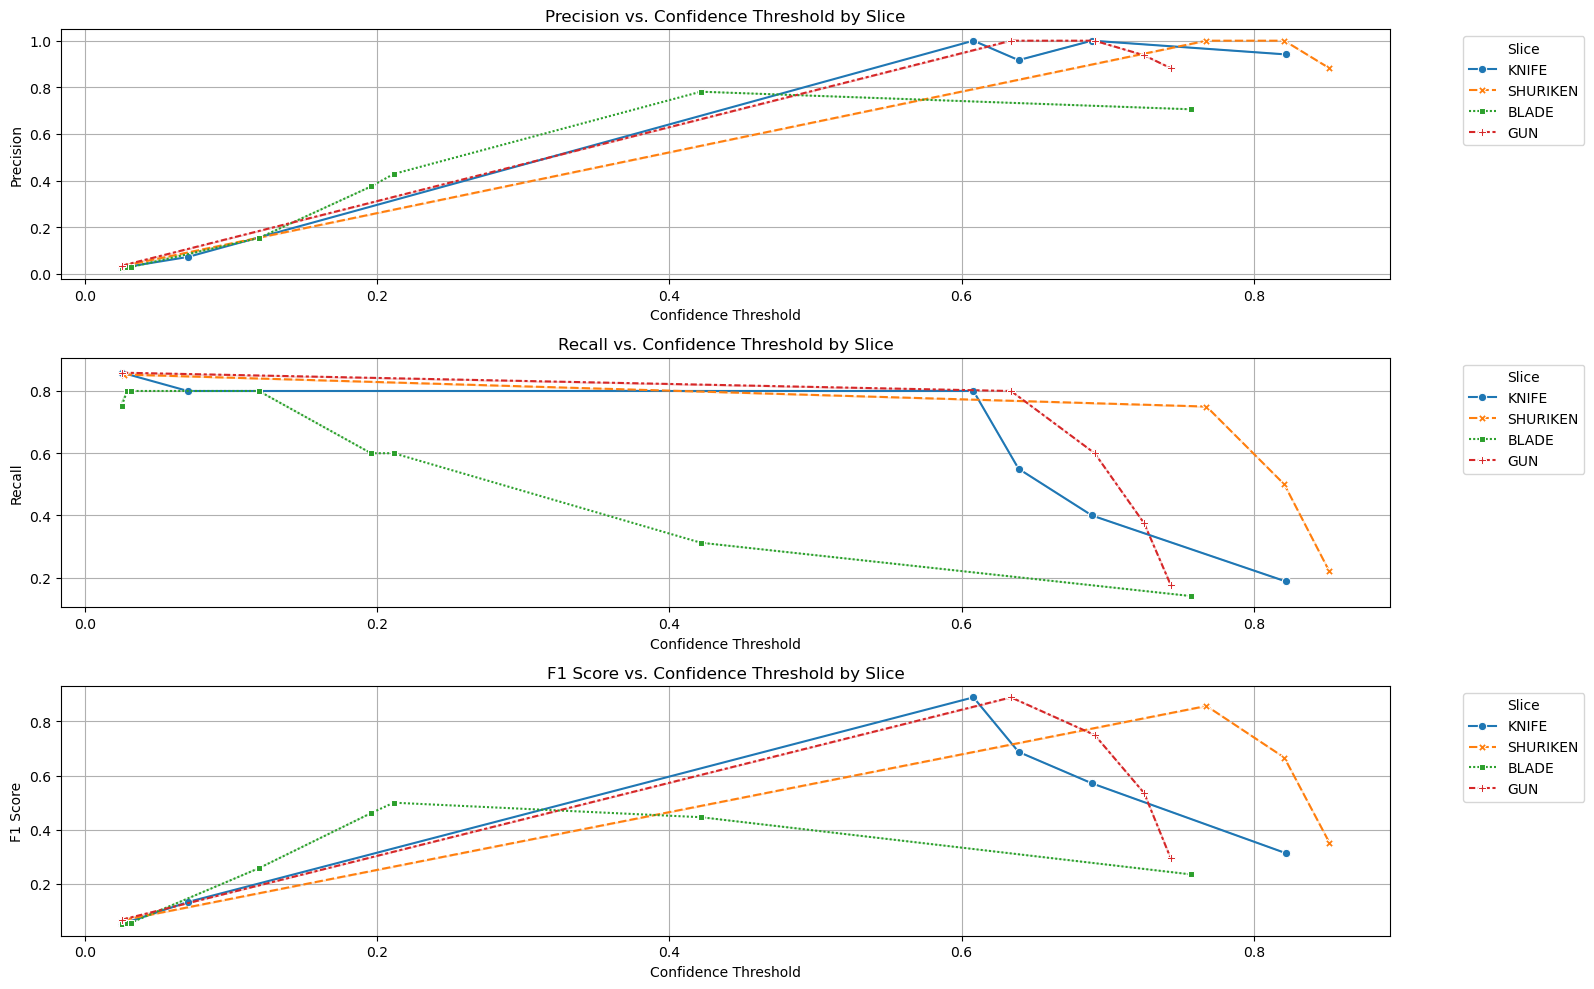

In [226]:
plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)  
sns.lineplot(data=slice_score_df, x="Confidence Threshold", y="Precision", hue="Slice", style="Slice", markers=True, legend="full", errorbar=('ci', False))
plt.title("Precision vs. Confidence Threshold by Slice")
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.grid(True)
plt.legend(title="Slice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(3, 1, 2) 
sns.lineplot(data=slice_score_df, x="Confidence Threshold", y="Recall", hue="Slice", style="Slice", markers=True, legend="full", errorbar=('ci', False))
plt.title("Recall vs. Confidence Threshold by Slice")
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.grid(True)
plt.legend(title="Slice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(3, 1, 3) 
sns.lineplot(data=slice_score_df, x="Confidence Threshold", y="F1 Score", hue="Slice", style="Slice", markers=True, legend="full", errorbar=('ci', False))
plt.title("F1 Score vs. Confidence Threshold by Slice")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend(title="Slice", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()

plt.show()

<div class="alert alert-info" role="alert">
Similar thing can be said here with performance peaking at around 0.6 confidence threshold.
</div>

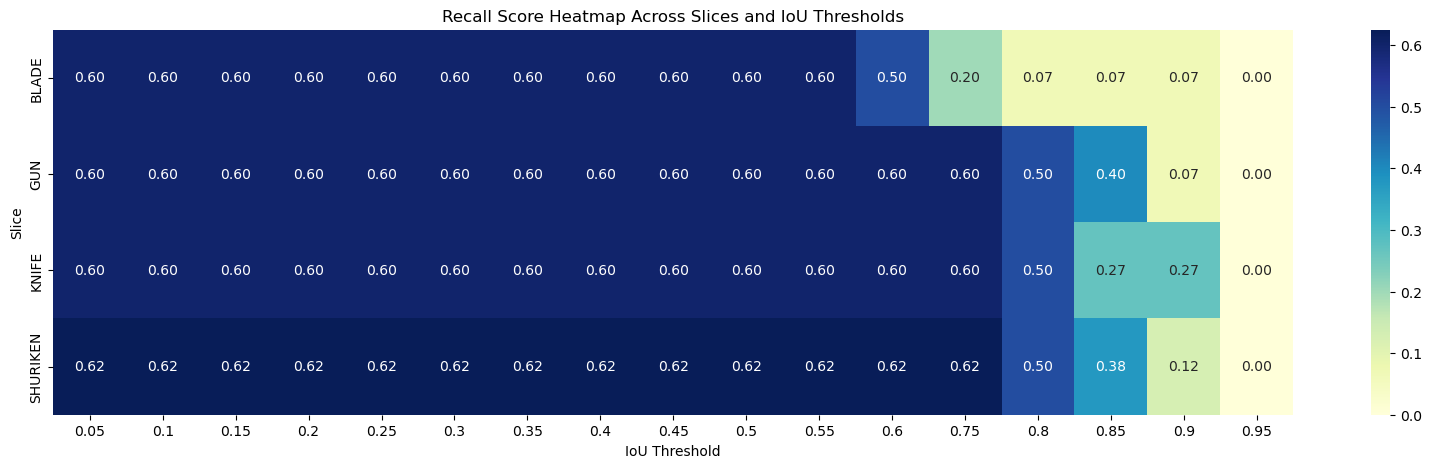

In [192]:
metrics_pivot = slice_score_df.pivot_table(
    values="Recall", index="Slice", columns="IoU Threshold", aggfunc="mean"
)

plt.figure(figsize=(20,5))
sns.heatmap(metrics_pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Recall Score Heatmap Across Slices and IoU Thresholds")
plt.xlabel("IoU Threshold")
plt.ylabel("Slice")
plt.show()

<div class="alert alert-info" role="alert">
Since recall is the recommended metric, the performance for all classes is very good at an IOU threshold of 0.6 after which it tends to decrease signficantly. 
</div>

<div class="alert alert-info" role="alert"> Based on the analysis, it is recommended to set the confidence threshold and IoU threshold to 0.6. This configuration ensures a favorable recall score while maintaining a balanced performance across other metrics and minimizing the impact on the performance of other classes. </div>

### Deploy Model & Prediction

Reference: [predictions.deploy-model-api](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api)

Steps
1. Prepare your test images
2. Create an endpoint
3. Deploy your model into the endpoint
4. Perform prediction on your model
5. Undeploy your model in endpoint

Having an endpoint does not incur charges. The **deployed model** in your endpoint incurs charges so you must undeploy after prediction. In other words, once you execute step 3, complete step 4 and 5 as soon as possible to minimise your charges.

**Prepare your test images**

Prepare your test images required for online prediction. Once done, proceed on.

In [239]:
# model is from dag.run(); not empty
model

resource name: projects/101663845876/locations/us-central1/models/4546266176086343680

*Example output:*
```
<google.cloud.aiplatform.models.Model object at 0x000001F415006BB0> 
resource name: projects/636590004944/locations/us-central1/models/486659239616446464
```

In [240]:
# if model is empty (e.g. kernel died), retrieve a reference from the server 
# models = aip.Model.list()
# model = models[0]

In [246]:
# should be empty [] because there is no endpoint yet
aip.Endpoint.list()

 resource name: projects/101663845876/locations/us-central1/endpoints/7239898140323610624]

**Create an Endpoint**

In [247]:
endpoint = aip.Endpoint.create(display_name=display_name)

Creating Endpoint
Create Endpoint backing LRO: projects/101663845876/locations/us-central1/endpoints/5207085858519252992/operations/3763876138670096384
Endpoint created. Resource name: projects/101663845876/locations/us-central1/endpoints/5207085858519252992
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/101663845876/locations/us-central1/endpoints/5207085858519252992')


*Example output:*
<pre>
Creating Endpoint
Create Endpoint backing LRO: projects/636590004944/locations/us-central1/endpoints/304470162893963264/operations/2602331198726340608
<span style="background-color: #FFFF00">Endpoint created.</span> Resource name: projects/636590004944/locations/us-central1/endpoints/304470162893963264
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/636590004944/locations/us-central1/endpoints/304470162893963264')
</pre>

**Deploy your model into the endpoint**

Next, deploy your model for online prediction. To deploy the model, invoke the `deploy` method.

<span style="color:red">&#x26A0; Note that once you deploy your model, charges would be incurred until you undeploy your model.</span>

In [404]:
# deploy model into endpoint; might take 10 mins or more
endpoint.deploy(model)

Deploying Model projects/101663845876/locations/us-central1/models/4546266176086343680 to Endpoint : projects/101663845876/locations/us-central1/endpoints/5207085858519252992
Deploy Endpoint model backing LRO: projects/101663845876/locations/us-central1/endpoints/5207085858519252992/operations/804883640138858496
Endpoint model deployed. Resource name: projects/101663845876/locations/us-central1/endpoints/5207085858519252992


*Example output:*
<pre>
Deploying Model projects/636590004944/locations/us-central1/models/486659239616446464 to Endpoint : projects/636590004944/locations/us-central1/endpoints/304470162893963264
Deploy Endpoint model backing LRO: projects/636590004944/locations/us-central1/endpoints/304470162893963264/operations/6658807825591959552
<span style="background-color: #FFFF00">Endpoint model deployed.</span> Resource name: projects/636590004944/locations/us-central1/endpoints/304470162893963264
</pre>

In [405]:
# should only have one model
aip.Endpoint.list_models(endpoint)

[id: "2897332985957187584"
 model: "projects/101663845876/locations/us-central1/models/4546266176086343680"
 display_name: "threat_detector_v1"
 create_time {
   seconds: 1733625633
   nanos: 56379000
 }
 automatic_resources {
   min_replica_count: 1
   max_replica_count: 1
 }
 disable_container_logging: true
 model_version_id: "1"]

*Example output:*
<pre>
[id: "6229034637537050624"
 model: "projects/636590004944/locations/us-central1/models/486659239616446464"
 display_name: "masks"
 create_time {
   seconds: 1699693631
   nanos: 904107000
 }
 automatic_resources {
   min_replica_count: 1
   max_replica_count: 1
 }
 disable_container_logging: true
 model_version_id: "1"]
</pre>

**Perform prediction on your model**

Reference: [Get predictions from a image object detection model](https://cloud.google.com/vertex-ai/docs/image-data/object-detection/evaluate-model)

Now that your `Model` resource is deployed to an `Endpoint` resource, you can do online predictions by sending prediction requests to the Endpoint resource.

In [406]:
# helper function
def get_base64(image_filename):
    with open(image_filename, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    return encoded_string

In [408]:
# example of performing prediction

import base64

img_filename = 'test_threat_items_dataset/bag_0267_rf_ef9d9c2c6e9a83a372950667cc58234d.jpg'

# The format of each instance should conform to the deployed model's prediction input schema.
instances = [{"content": get_base64(img_filename).decode("utf-8")}]

prediction = endpoint.predict(instances=instances)

print(prediction)

Prediction(predictions=[{'confidences': [0.727152884, 0.212844744, 0.0968387723, 0.0922741145, 0.0752099082, 0.0667339, 0.0624127872, 0.0611688793, 0.0586085171, 0.0574088953, 0.0551434457, 0.0520159192, 0.0484753, 0.0481902, 0.0480465218, 0.0462745316, 0.0462256, 0.0449349284, 0.042940747, 0.0428727269, 0.0427884534, 0.0414580628, 0.0411433466, 0.0410435386, 0.0390965529, 0.0383969396, 0.0372279398, 0.0372085311, 0.0370420814, 0.0360075124, 0.0357847922, 0.0353297591, 0.0352618583, 0.0351630412, 0.0349254832, 0.0347473472, 0.0347186, 0.0345207416, 0.0344639942, 0.0344304591], 'bboxes': [[0.276493847, 0.579669237, 0.214577645, 0.663996816], [0.21040386, 0.598761499, 0.121963441, 0.757139146], [0.276493847, 0.579669237, 0.214577645, 0.663996816], [0.267915249, 0.598355234, 0.238060474, 0.679376364], [0.273656726, 0.590464, 0.238762051, 0.665411949], [0.191417322, 0.616355658, 0.0891497731, 0.779234409], [0.135827512, 0.664520621, 0.235240787, 0.848686099], [0.292828202, 0.686794043, 0.3

In [409]:
# function to randomly pick 3 images and make predictions
def predict_random_images(folder_path, endpoint):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    selected_files = random.sample(all_files, 3)
    
    results = {}

    for img_filename in selected_files:
        instance = [{"content": get_base64(img_filename).decode("utf-8")}]
        prediction = endpoint.predict(instances=instance)
        results[img_filename] = prediction
        
    return results

folder_path = "test_threat_items_dataset/"
predictions_dict = predict_random_images(folder_path, endpoint)

for file_path, prediction in predictions_dict.items():
    print(f"File: {file_path}")
    print(f"Prediction: {prediction}")
    print("\n")

File: test_threat_items_dataset/bag_1169_rf_ce077eb6a5d852a4a9d788ee011d7df6.jpg
Prediction: Prediction(predictions=[{'bboxes': [[0.32013905, 0.57047379, 0.00214552879, 0.244873986], [0.259353191, 0.626799941, 0.0272247493, 0.291859567], [0.327545971, 0.575373232, 0.0, 0.242018864], [0.206331402, 0.637732, 0.010764733, 0.153982058], [0.317385077, 0.552924037, 0.00207493454, 0.23099792], [0.32699427, 0.545030236, 0.0225629285, 0.187324017], [0.359083921, 0.557846129, 0.0390013, 0.294830501], [0.130216449, 0.739590406, 0.0, 0.188272], [0.325785458, 0.595509708, 0.00684581697, 0.272870958], [0.283326805, 0.599035263, 0.0237670615, 0.190263391], [0.314190805, 0.694828, 0.0, 0.353499949], [0.217833623, 0.686453104, 0.0, 0.238554284], [0.275876164, 0.515064657, 0.00168826431, 0.214292645], [0.259353191, 0.626799941, 0.0272247493, 0.291859567], [0.315238744, 0.562077224, 0.0506449938, 0.14047873], [0.242386669, 0.601127267, 0.0573082343, 0.228371143], [0.347300977, 0.712996244, 0.0, 0.1725483

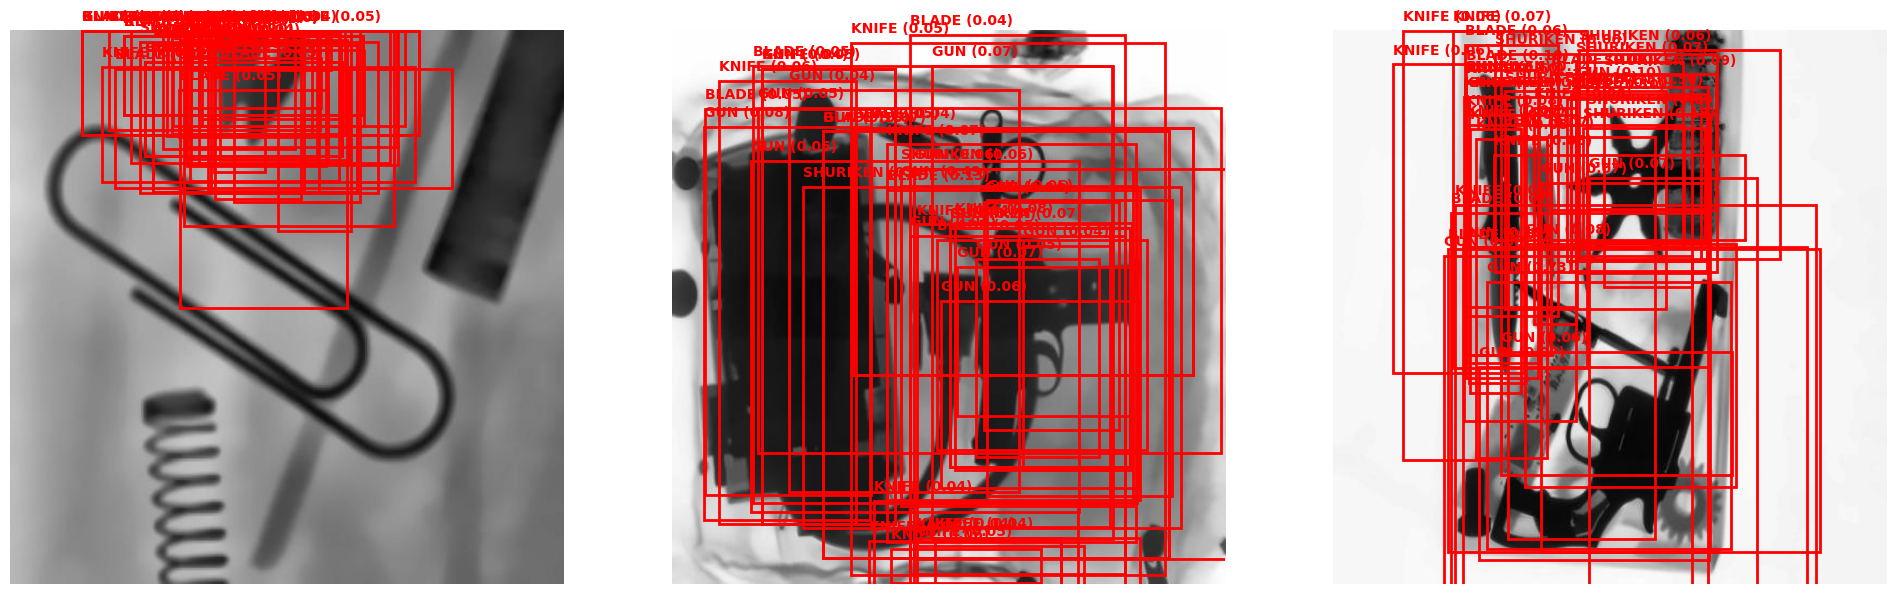

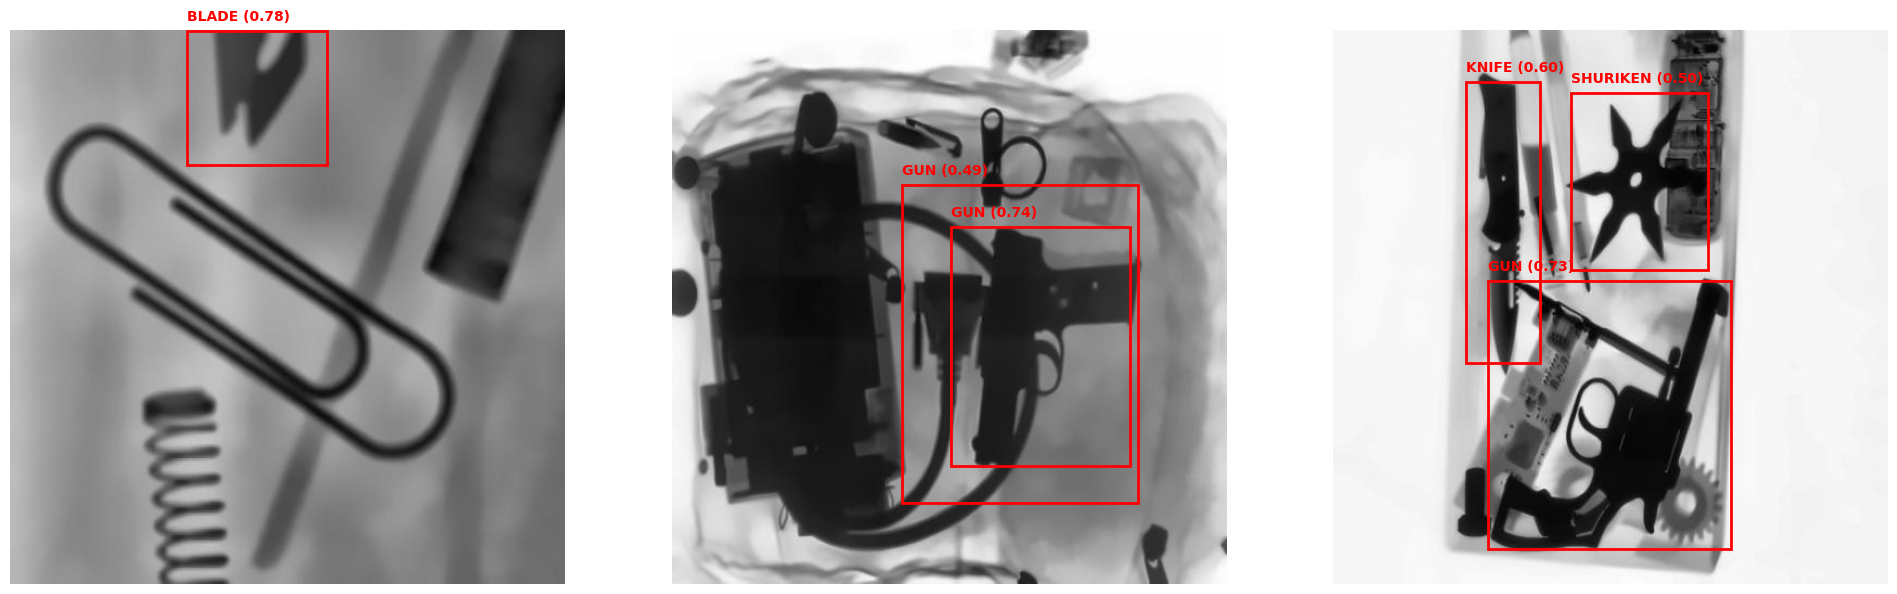

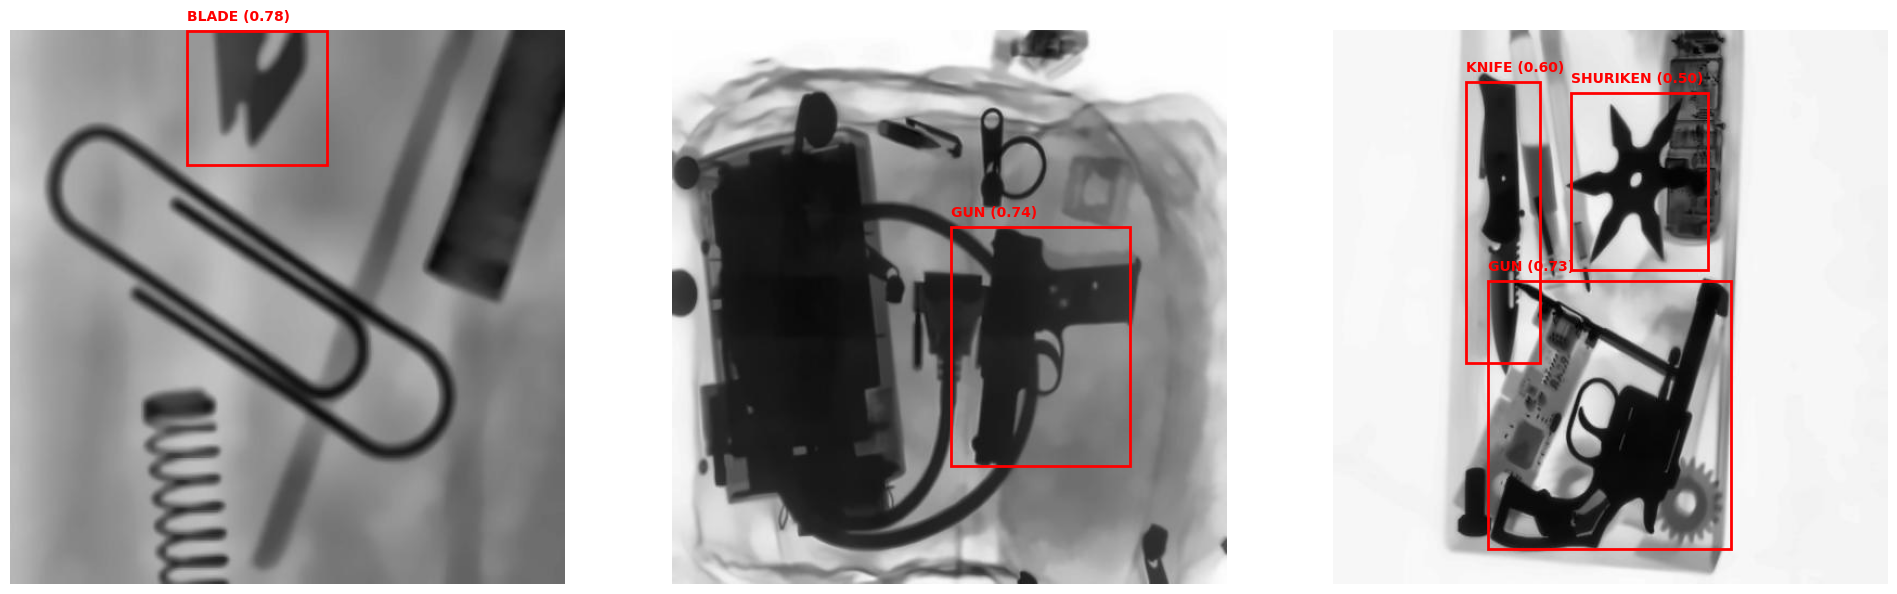

In [418]:
def denormalize_bbox(bbox, image_shape):
    height, width = image_shape[:2]
    xmin, ymin, xmax, ymax = bbox
    xmin = int(xmin * width)
    ymin = int(ymin * height)
    xmax = int(xmax * width)
    ymax = int(ymax * height)
    return xmin, ymin, xmax, ymax


def plot_predictions(predictions_dict, figsize=(20, 6), max_images=3, conf_threshold=0.2):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    for idx, (image_path, content) in enumerate(predictions_dict.items()):
        if idx >= max_images:
            break
        
        image = Image.open(image_path)
        ax = axes[idx]
        ax.imshow(image)
        ax.axis('off')
        
        predictions = content.predictions[0]
        bboxes = predictions['bboxes']
        confidences = predictions['confidences']
        labels = predictions['displayNames']
        
        for bbox, confidence, label in zip(bboxes, confidences, labels):
            if confidence > conf_threshold:
                xmin, xmax, ymin, ymax = denormalize_bbox(bbox, (512, 512))
                
                rect = patches.Rectangle(
                    (xmin, ymin), 
                    xmax - xmin, 
                    ymax - ymin,
                    linewidth=2, 
                    edgecolor='red', 
                    facecolor='none'
                )
                ax.add_patch(rect)
                
                ax.text(
                    xmin, ymin - 10, 
                    f'{label} ({confidence:.2f})',
                    color='red', 
                    fontsize=10, 
                    weight='bold'
                )
    
    plt.tight_layout()
    plt.show()

plot_predictions(predictions_dict, conf_threshold=0.0)
plot_predictions(predictions_dict, conf_threshold=0.3)
plot_predictions(predictions_dict, conf_threshold=0.5)

In [411]:
test_df = pd.read_csv("testing_dataset.csv")
test_df.file_path = test_df['file_path'].apply(lambda x: x.split("/")[-1])
test_df.file_path = test_df.file_path.str.lower()
test_df.file_path = test_df['file_path'].apply(lambda x: x.replace("_png.", "_"))
test_df.file_path = test_df['file_path'].str.replace("rf.", "rf_")
test_df

,file_path,obj_label,x_min,y_min,e1,e2,x_max,y_max,e3,e4
0,bag_0853_rf_716ea1cff9a7f02ccb079f7b176b3e03.jpg,SHURIKEN,0.146875,0.489063,NaN,NaN,0.437500,0.848437,NaN,NaN
1,bag_0853_rf_716ea1cff9a7f02ccb079f7b176b3e03.jpg,BLADE,0.593750,0.331250,NaN,NaN,0.675000,0.509375,NaN,NaN
2,bag_0853_rf_716ea1cff9a7f02ccb079f7b176b3e03.jpg,SHURIKEN,0.146875,0.489063,NaN,NaN,0.437500,0.848437,NaN,NaN
3,bag_0853_rf_716ea1cff9a7f02ccb079f7b176b3e03.jpg,BLADE,0.593750,0.331250,NaN,NaN,0.675000,0.509375,NaN,NaN
4,bag_0107_rf_b4e49b50080ce7b603d9eb24f58a28e2.jpg,GUN,0.420312,0.220312,NaN,NaN,0.812500,0.643750,NaN,NaN
5,bag_0779_rf_cb2944abe0ef85f6f75638ac3e80d835.jpg,SHURIKEN,0.420312,0.118750,NaN,NaN,0.668750,0.423438,NaN,NaN
6,bag_0779_rf_cb2944abe0ef85f6f75638ac3e80d835.jpg,GUN,0.275000,0.443750,NaN,NaN,0.710938,0.960938,NaN,NaN
7,bag_0779_rf_cb2944abe0ef85f6f75638ac3e80d835.jpg,KNIFE,0.250000,0.076563,NaN,NaN,0.370312,0.614062,NaN,NaN
8,bag_0368_rf_8b2ffca6e2f444bdc1e4d719e53a6ce7.jpg,BLADE,0.237500,0.320312,NaN,NaN,0.406250,0.525000,NaN,NaN
9,bag_0228_rf_584a97156db51612b38b5804241334d8.jpg,GUN,0.117188,0.209375,NaN,NaN,0.556250,0.673438,NaN,NaN


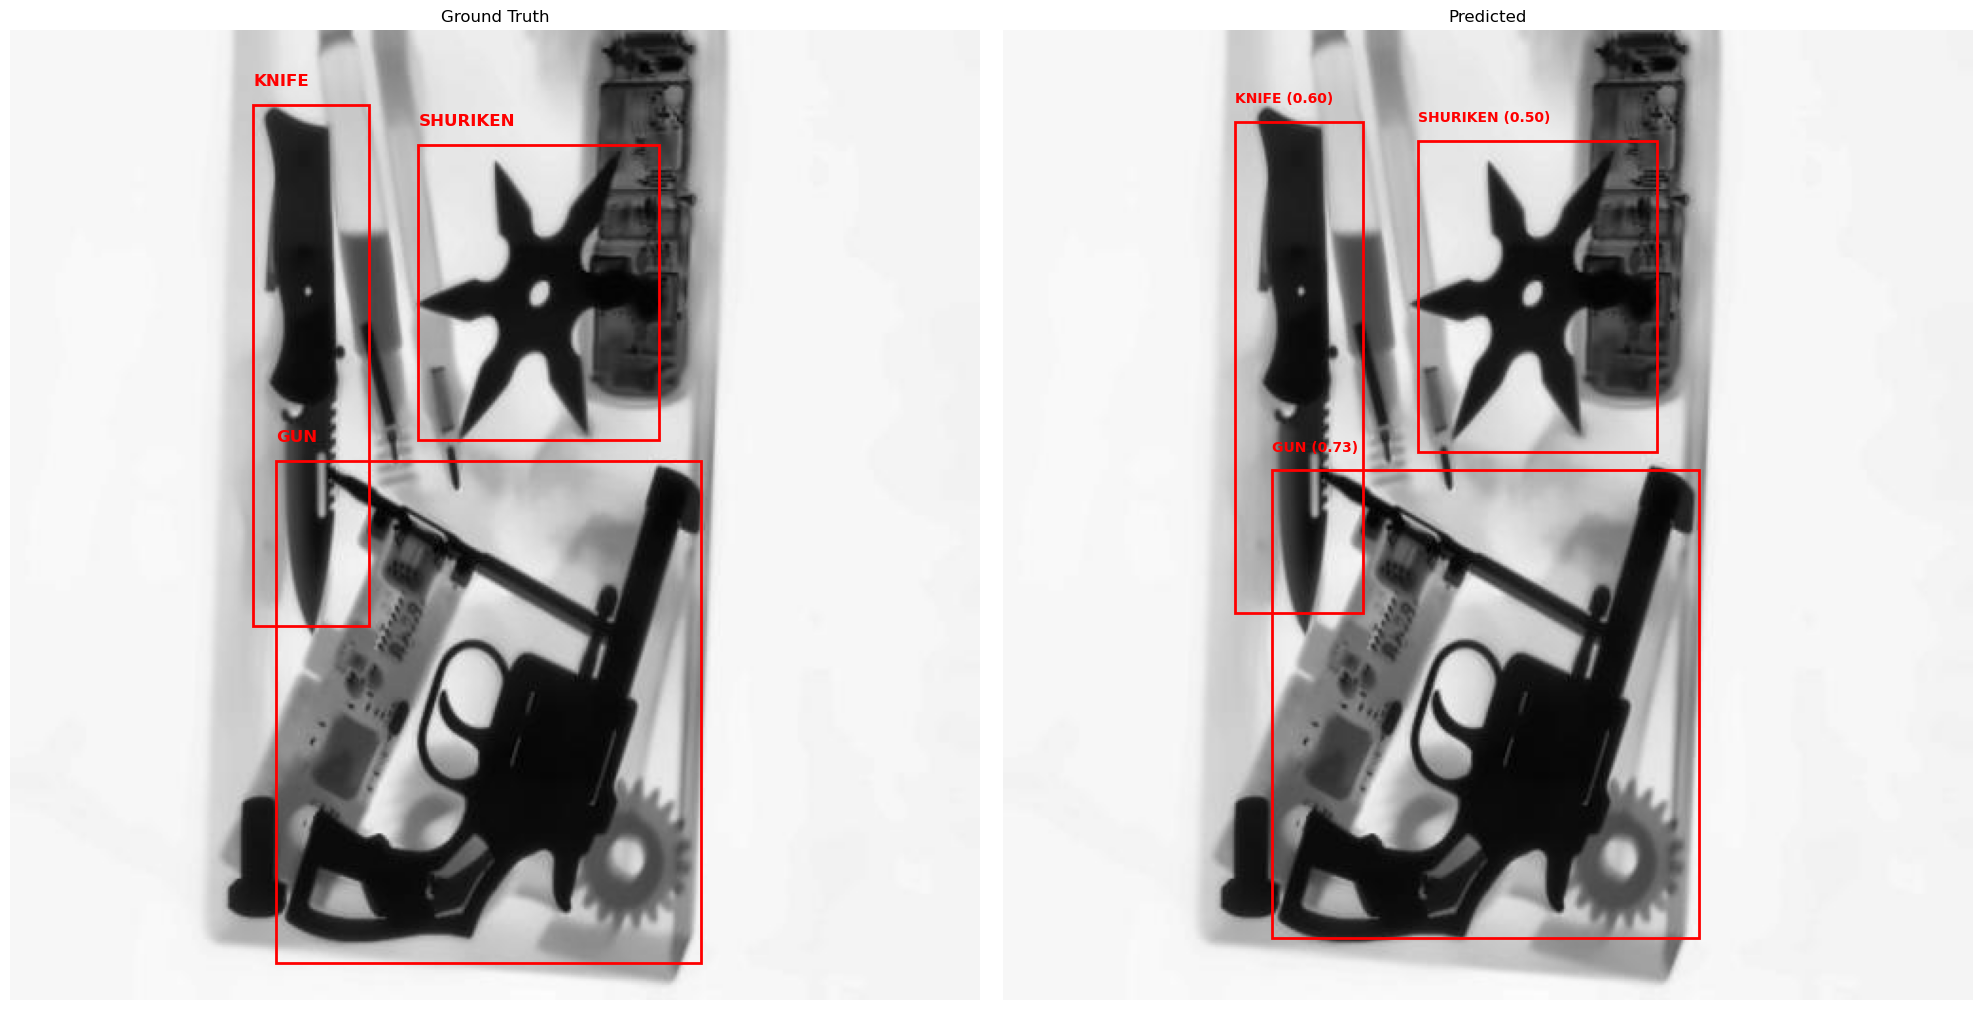

In [490]:
file_path = 'bag_0779_rf_cb2944abe0ef85f6f75638ac3e80d835.jpg'
image_data = test_df[test_df['file_path'] == file_path]
image = Image.open(f"./test_threat_items_dataset/{file_path}")

pred_data = predictions_dict[f'test_threat_items_dataset/{file_path}'].predictions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

gt_bbox = [
    {
        row['obj_label']: [
            int(row['x_min'] * 512), 
            int(row['y_min'] * 512), 
            int(row['x_max'] * 512), 
            int(row['y_max'] * 512)
        ]
    } 
    for _, row in image_data.iterrows()
]

ax1.imshow(image)
ax1.set_title('Ground Truth')
for bbox in gt_bbox:
    for label, coords in bbox.items():
        x_min, y_min, x_max, y_max = coords
        ax1.add_patch(
            patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
        )
        ax1.text(x_min, y_min - 10, label, color='red', fontsize=12, weight='bold')
ax1.axis('off')

pred_bbox = []
ax2.imshow(image)
ax2.set_title('Predicted')
for bbox, confidence, label in zip(pred_data[0]['bboxes'], pred_data[0]['confidences'], pred_data[0]['displayNames']):
    if confidence > 0.5:
        xmin, xmax, ymin, ymax = denormalize_bbox(bbox, (512, 512))
        pred_bbox.append({label: [xmin, ymin, xmax, ymax]})
        ax2.add_patch(
            patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
        )
        ax2.text(xmin, ymin - 10, f'{label} ({confidence:.2f})', color='red', fontsize=10, weight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()


In [494]:
pred_bbox, gt_bbox

([{'GUN': [142, 232, 367, 479]},
  {'KNIFE': [122, 48, 190, 307]},
  {'SHURIKEN': [219, 58, 345, 222]}],
 [{'SHURIKEN': [215, 60, 342, 216]},
  {'GUN': [140, 227, 364, 492]},
  {'KNIFE': [128, 39, 189, 314]}])

In [499]:
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    x_left, y_top = max(x1_min, x2_min), max(y1_min, y2_min)
    x_right, y_bottom = min(x1_max, x2_max), min(y1_max, y2_max)

    intersection = max(0, x_right - x_left) * max(0, y_bottom - y_top)
    union = ((x1_max - x1_min) * (y1_max - y1_min)) + ((x2_max - x2_min) * (y2_max - y2_min)) - intersection

    return intersection / union if union > 0 else 0


def match_iou(gt_bboxes, pred_bboxes):
    label_ious = {}
    for gt in gt_bboxes:
        gt_label, gt_box = list(gt.items())[0]
        matching_preds = [pred[gt_label] for pred in pred_bboxes if gt_label in pred]

        if matching_preds:
            best_iou = max(calculate_iou(gt_box, pred_box) for pred_box in matching_preds)
        else:
            best_iou = 0

        label_ious[gt_label] = best_iou

    return label_ious


label_ious = match_iou(gt_bbox, pred_bbox)

for label, iou in label_ious.items():
    print(f"IoU for {label}: {iou:.2f}")

mean_iou = np.mean(list(label_ious.values()))
print(f"Mean IoU: {mean_iou:.2f}")

IoU for SHURIKEN: 0.90
IoU for GUN: 0.91
IoU for KNIFE: 0.85
Mean IoU: 0.89


<div class="alert alert-info" role="alert">
A high IOU can be seen for this example with a confidence threshold of 0.5 used. It is important to test with multiple images and filter those bounding boxes which are below the IOU threshold as they would not be localizing around the objects properly. 
</div>

*Example output:*
<pre>
Prediction(predictions=[{'displayNames': ['no-mask', 'mask', 'mask', 'no-mask', 'mask', 'mask', 'no-mask', 'mask', 'mask', 'no-mask', 'mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'mask', 'no-mask', 'mask', 'no-mask', 'no-mask', 'mask', 'mask', 'no-mask', 'no-mask', 'no-mask', 'no-mask', 'mask', 'no-mask', 'mask', 'mask', 'no-mask', 'mask', 'mask', 'no-mask', 'mask'], 'bboxes': [[0.612416506, 0.721348166, 0.0849742517, 0.333771944], [0.614177704, 0.720018744, 0.0977385491, 0.326078594], [0.768275619, 0.876894355, 0.255662382, 0.510935903], [0.307019472, 0.363261521, 0.0968781412, 0.273472], [0.0007789433, 0.0731677711, 0.230838388, 0.396583587], [0.13751629, 0.263617754, 0.226785541, 0.46154958], [0.619913, 0.705689192, 0.0279303044, 0.390545487], [0.376155376, 0.459880233, 0.201777428, 0.330048054], [0.303991407, 0.368028671, 0.106270224, 0.263946], ...
</pre>

**Undeploy your model in endpoint**

When you are done with predictions, undeploy the model from the `Endpoint` resouce. This stops all compute resources and ends billing for the deployed model.

<span style="color:red">Once you undeploy your model, you will not be able to perform any predictions so make sure you have gathered all the results you need before you undeploy. You will be penalised under Resource Management if you fail to undeploy your model within stipulated durations.</span>

In [413]:
endpoint.undeploy_all()

Undeploying Endpoint model: projects/101663845876/locations/us-central1/endpoints/5207085858519252992
Undeploy Endpoint model backing LRO: projects/101663845876/locations/us-central1/endpoints/5207085858519252992/operations/8109722235733803008
Endpoint model undeployed. Resource name: projects/101663845876/locations/us-central1/endpoints/5207085858519252992


resource name: projects/101663845876/locations/us-central1/endpoints/5207085858519252992

*Example output:*
<pre>
Undeploying Endpoint model: projects/636590004944/locations/us-central1/endpoints/304470162893963264
Undeploy Endpoint model backing LRO: projects/636590004944/locations/us-central1/endpoints/304470162893963264/operations/5818886495087362048
<span style="background-color: #FFFF00">Endpoint model undeployed.</span> Resource name: projects/636590004944/locations/us-central1/endpoints/304470162893963264
<google.cloud.aiplatform.models.Endpoint object at 0x000001F415571220> 
resource name: projects/636590004944/locations/us-central1/endpoints/304470162893963264
</pre>

In [449]:
# must be empty [] (i.e. there is no model deployed in the endpoint); inform tutor if otherwise
aip.Endpoint.list_models(endpoint)

[]

> &#128161; **Progress Check #3** - Vertex AI console 

## Reflection

Summarise main points here.

<div class="alert alert-info" role="alert">

**KEY POINTS**    
    

- **Overlapping Detections:** Images show overlapping bounding boxes with varying confidence scores, highlighting some redundancy that may affect recall.
    
- **Blade Class Challenges:** The blade class performs poorly with low confidence, requiring more data and retraining to improve recall, while other classes perform well.
    
- **Threshold Recommendations for Recall:** A confidence threshold of 0.6 and an IOU threshold of 0.6 are ideal for maximizing recall across most classes. However, blade detection improves at a lower confidence threshold of 0.2. 
    
- **Recall as a Priority:** Recall is emphasized to minimize false negatives and ensure threats are not missed, even if it increases false positives.
    
- **Optimizing for Recall:** Lower confidence thresholds (~0.2) paired with an IOU threshold of ~0.6 enhance recall, while thresholds around ~0.4 and IOU values of ~0.15–0.30 can balance precision and recall effectively.
</div>

<div class="alert alert-success" role="alert">

**Recommendations:**
    
- **Bounding Box Validation:** Check for overlaps between bounding boxes to refine results (e.g., through non-maximum suppression). Additionally there are some images which are labelled incorrectly, causing the model to make wrong assumptions, these need to be addressed in future stages.<br><br>
- **Model Refinement:** Continue to train the model for a longer time and procure more images to allow for better generalization by the model, especially images of those labels which are underperforming. If false positives or missed detections are significant, consider retraining the model with improved annotations or additional data.<br><br>
- **Custom Solutions:** If the model is to be used extensively and at a very large scale, training a custom model through transfer learning can also be considered. The YOLO family of models is suitable for this task and can perform very well. 
</div>